In [2]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

2024-06-16 00:10:20.142198: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 00:10:20.142351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 00:10:20.324178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def armazenar_nomes_arquivos(caminho):
    nomes_arquivos = []
    for filename in os.listdir(caminho):
        filepath = os.path.join(caminho, filename)
        nomes_arquivos.append(filepath)

    return nomes_arquivos

def criar_df_classe_unica(nomes_arquivos, label):
    labels = []
    for i in range(len(nomes_arquivos)):
        labels.append(label)

    df_classe_unica = pd.DataFrame({'nomes_arquivos': nomes_arquivos, 'labels': labels})

    return df_classe_unica

def rotacionar_imagem(imagem):
    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

    _, imagem_bin = cv2.threshold(imagem_cinza, 127, 255, cv2.THRESH_BINARY)

    contornos, _ = cv2.findContours(imagem_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    maior_contorno = max(contornos, key=cv2.contourArea)
    
    rect = cv2.minAreaRect(maior_contorno)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    _, dimensoes, angulo = rect
    
    largura, altura = dimensoes
    if largura < altura:
        angulo = angulo + 90 

    altura, largura = imagem.shape[:2]
    centro = (largura // 2, altura // 2)
    matriz_rotacao = cv2.getRotationMatrix2D(centro, angulo, 1.0)
    imagem_rotacionada = cv2.warpAffine(imagem, matriz_rotacao, (largura, altura))
    
    return imagem_rotacionada

# Importação das Imagens

In [5]:
kirmizi_path = '/kaggle/input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio'
siirt_path = '/kaggle/input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset/Siirt_Pistachio'

kirmizi_arquivos = armazenar_nomes_arquivos(kirmizi_path)
df_kirmizi = criar_df_classe_unica(kirmizi_arquivos, 'kirmizi')

siirt_arquivos = armazenar_nomes_arquivos(siirt_path)
df_siirt = criar_df_classe_unica(siirt_arquivos, 'siirt')

df = pd.concat([df_kirmizi, df_siirt], axis=0, ignore_index=True)


##Label = 1 -> Kirmizi e label = 0 -> Siirt
df['labels'] = df['labels'].map({'kirmizi': 1, 'siirt': 0})

X = df['nomes_arquivos']
y = df['labels']

# Redimensionamento e Alinhamento das Imagens

In [6]:
imagens_rotacionadas = []
for arquivo in X:
    imagem = cv2.imread(arquivo)
    nl, nc, num_canais = imagem.shape
    imagem_resize = cv2.resize(imagem, None, fx=0.5, fy=0.5)
    imagem_rotacionada = rotacionar_imagem(imagem_resize)
    imagens_rotacionadas.append(imagem_rotacionada)

imagens_rotacionadas = np.array(imagens_rotacionadas)
print(imagens_rotacionadas.shape)

(2148, 300, 300, 3)


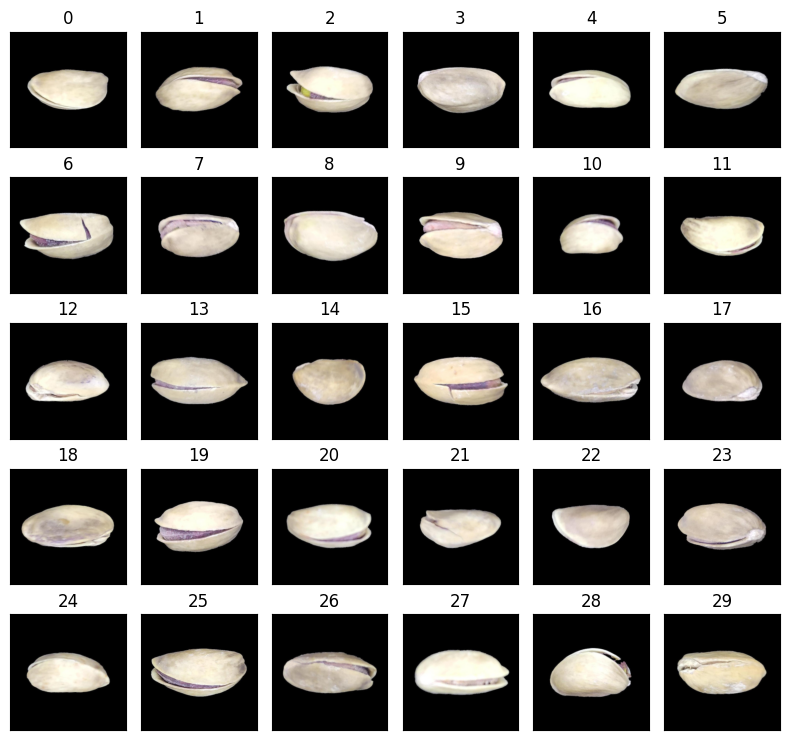

In [7]:
fig, axs = plt.subplots(5, 6, figsize=(8, 8))
axs = axs.reshape(-1)


for i, imagem_rotacionada in enumerate(imagens_rotacionadas):
    if i == 30:
        break
    
    imagem_rotacionada = cv2.cvtColor(imagem_rotacionada, cv2.COLOR_BGR2RGB)
    axs[i].imshow(imagem_rotacionada)
    axs[i].set_title(str(i))
    axs[i].set_xticks([])  
    axs[i].set_yticks([])
    plt.tight_layout()